# Pyro 中的推断

许多现代机器学习方法都可以转换为近似推断问题，并且可以用 Pyro 之类的概率编程语言简洁地表达出来。为了引出本教程其余部分，让我们为一个简单的物理问题构建一个生成模型，以便使用 Pyro 的推断机制来给出相应的解。

首先导入本教程所需的模块：

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

## 1 从一个简单案例开始

假设我们试图计算某个物体的重量，但使用的秤不可靠，每次称量同一物体时给出的答案略有不同。可以尝试将这些含噪声的测量数据与`我们基于某些先验知识（如物体的密度或材料特性等）做出的猜测` 相结合，来补偿这种变化性。

以下模型对此过程进行编码：

$$
{\sf weight} \mid {\sf guess} \sim {\sf Normal}({\sf guess}, 1)
$$

$$
{\sf measurement} \mid {\sf guess}, {\sf weight} \sim {\sf Normal}({\sf weight}, 0.75)
$$

请注意，这不仅是我们关于重量的信念模型，也是对其进行测量的结果模型。该模型对应于下面的 `scale` 随机函数：

In [6]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

## 2 `pyro.condition` 条件元语和 `pyro.do` 因果推断元语

概率编程的真正作用在于：**能够根据观测数据条件（观测量）来调整生成模型，并推断可能产生此数据的潜在因素（隐变量及其结构）。**

在 Pyro 中，我们通过推断将 `确定条件表达式的过程（即推断过程）` 和 `利用条件表达式进行计算的过程（即预测过程）` 分开，从而可以一次性地编写模型， 然后多次为不同的观测进行条件化计算。 Pyro 支持将模型内的 `sample` 语句，约束为指定的一组观测数据，从而支持推断任务。

再看看  `scale` 模型 。假设想从给定输入 `guess = 8.5` 的分布 `weight` 中采样，但现在已经观察到了  `measurement = 9.5`。也就是说，我们希望推断出条件分布：

$$
({\sf weight} \, | \, {\sf guess}, {\sf measurement} = 9.5) \sim \, ? 
$$

Pyro 提供了 `pyro.condition` 元语，允许我们限制 `sample` 语句的值。 `pyro.condition` 是一个高阶函数，它接受一个模型和一个观测数据字典，然后返回一个新模型，新模型具有与原模型相同的输入和输出形式，但始终使用给定的观测值：

In [7]:
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(9.5)})

 `pyro.condition` 元语的行为就像一个普通的 Python 函数，可以用 Python 的 `lambda` 或 `def` 来给 `pyro.condition` 做 `defer` 和参数化。

In [8]:
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)

在某些情况下，将观测数据直接传递给单独的 `pyro.sample` 语句可能比使用 `pyro.condition` 更方便。因此， `pyro.sample` 保留了可选的 `obs` 关键字参数用于此目的：

In [9]:
def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=torch.tensor(9.5))

最后，除了用于合并观测数据的 `pyro.condition` 之外，Pyro 还包含 `pyro.do` 元语，这是 Pearl 的 `do` 运算符的实现，主要用于因果推断，具有与 `pyro.condition` 相同的接口。 `condition` 和 `do` 可以自由混合和组合，使 Pyro 成为基于模型的强大因果推断工具。

## 3 使用引导进行灵活的近似推断

让我们回到 `conditional_scale`。现在可以以 `measurement` 观测数据为条件，使用 Pyro 的近似推断算法，来估计给定 `guess` 参数和 `measurement == data` 观测数据时 `weight`  的概率分布了。

Pyro 中的推断算法（ 例如： `pyro.infer.SVI` ）允许我们将任意随机函数作为近似后验分布。该随机函数后文中将被称为**引导函数**，或简称为**引导**（guide functions 或 guides）。引导必须满足两个标准才能成为特定模型的有效近似值： 

（1）在模型（ `model` ）中出现过的所有非观测变量，其 `sample` 语句在引导（ `guide` ）中也都必须要出现。 <br>
（2）引导（ `guide` ）具有与模型（ `model` ）相同的输入接口形式（即采用相同的参数）。<br>

> **重要提示**
> 
> 引导可以用作重要性采样、拒绝采样、序贯蒙特卡罗、MCMC 和独立 Metropolis-Hastings 等的可编程的、依赖于数据的提议分布，也可以作为随机变分推断（SVI）的变分分布或推断网络。目前，Pyro 中已经实现了重要性采样、MCMC 和随机变分推断，并计划在未来添加其他算法。

虽然不同推断算法中，引导的确切含义有所不同，但通常都需要对引导做出合理构造或选择，以便其足够灵活、并能够接近`模型`中所有非观测变量的 `sample` 分布（即后验分布）。

事实表明，在 `scale` 模型示例中，给定 `guess` 和 `measurement` 时， `weight` 的真实后验分布实际上是 ${\sf Normal}(9.14, 0.6)$ 。该模型比较简单，能够通过解析方式确定后验分布的表达形式（请参见 [有关推导](http://www.stat.cmu.edu/~brian/463-663/week09/Chapter%2003.pdf))。

In [10]:
def perfect_guide(guess):
    loc = (0.75**2 * guess + 9.5) / (1 + 0.75**2)  # 9.14
    scale = np.sqrt(0.75**2 / (1 + 0.75**2))  # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

## 4 用 `pyro.param` 元语指定变分参数|

尽管我们可以写出 `scale` 的精确后验分布，但这并不是最一般化的情况。大部分模型都很难指定一个能够良好近似于后验分布的引导。

事实上，能够精确确定真实后验分布的情况只是例外而不是常态。例如，随便一个中间带有非线性函数的 `scale` 模型版本，就可能是难以处理：

In [11]:
def intractable_scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(some_nonlinear_function(weight), 0.75))

我们能做的是使用元语 `pyro.param`  来命名变分参数，用命名参数来索引相应的引导（分布）族，然后根据某些损失函数在该引导族中搜索最佳近似值。这种近似后验推断方法被称为**变分推断** 。

在 Pyro 中，所有命名的变分参数都以 `key-value` 类型存储在全局 `参数存储库（Parameters Store）` 中。而 `pyro.param` 则是该存储库的前端。

与 `pyro.sample` 一样，`pyro.param` 总是以名称作为第一个参数来调用。第一次使用指定名称调用 `pyro.param` 时，它会将其参数存储在`参数存储库`中，并返回该参数值。之后，当使用该名称再次调用参数时，它会直接从`参数存储库`中返回值。它行为方式类似于下面的 `simple_param_store.setdefault`，但具有一些额外的跟踪和管理功能。

In [12]:
simple_param_store = {}
a = simple_param_store.setdefault("a", torch.randn(1))

例如，我们可以用 `scale_parametrized_guide` 中的 `a` 和 `b` 参数化，而不用人工单独指定：

In [13]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

请注意在 `scale_parametrized_guide` 中，必须将 `torch.abs` 应用于参数 `b`，因为正态分布的标准差必须为正；类似限制也适用于许多其他分布的参数。 Pyro 所基于的 PyTorch 概率分布库包括一个 [constraints 模块](https://pytorch.org/docs/master/distributions.html#module-torch.distributions.constraints) 用于强制执行此类限制，而在 Pyro 中，对变分参数做出约束只需要将 `constraint` 对象传递给 `pyro.param` 就可以：

In [14]:
from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

## 5 执行变分推断

Pyro 旨在启用**随机变分推断**，这是一类强大且广泛适用的变分推断算法，具有三个关键特征：

(1) 变分参数始终是实值张量。<br>
(2) 从`模型`和`引导`的历史执行样本来计算损失函数的蒙特卡罗估计。<br>
(3) 使用随机梯度下降（SGD）来搜索最优参数。<br>

将随机梯度下降与 PyTorch 的 GPU 加速张量计算和自动微分相结合，可以将变分推断扩展到高维参数空间和海量数据集，这也是变分推断方法近年重新兴起的主要原因。 

Pyro 的随机变分推断功能在 [SVI 教程](003_svi_part_i.ipynb) 中有详细描述。下面是一个非常简单的、应用到 `scale` 模型的例子：

a =  9.1148042678833
b =  0.6281598806381226


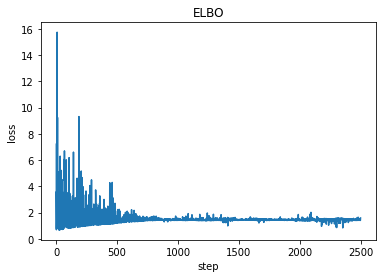

In [15]:
guess = 8.5

pyro.clear_param_store()

svi = pyro.infer.SVI(model=conditioned_scale, 
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.Adam({"lr": 0.003}),
                     loss=pyro.infer.Trace_ELBO())


losses, a, b = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())
    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

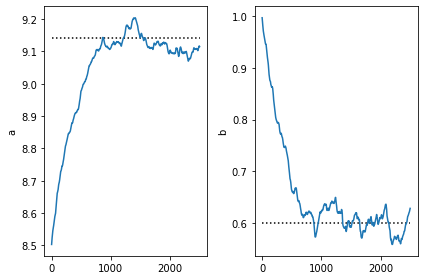

In [16]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

注意优化将更新`参数存储库(Parameters Store)`中的变分参数值，一旦找到好的参数值，就可以使用`引导`的样本执行下游任务。

## 6 下一步

在[变分自动编码器教程](vae.ipynb) 中，可以看到如何使用深度神经网络对类似 `scale` 的模型进行增强，并使用随机变分推断来构建图像的生成模型。